## EEG data of simple and compound limb motor imagery
There are ten files from ten subjects stored in three zip files: data1, data2 and data3.<br>
Each file contains EEG 'data' (Channel*Time*Trial) and labels.<br>
Data is from 64 channels. 560 trials, i.e. 560 =  80 x 7 classes each.<br>
So, eeg.shape == (64,1600,560).<br>
The data were band-pass filtered between 0.1 and 50Hz. <br>
Each EEG waveform is 8s long (1600 time points), <br>
sampling rate is 200Hz. There are 560 labels,  1-7 indicate <br>
left hand, right hand, both hands, feet, left hand combined with right foot, right hand <br>
combined with left foot and resting state respectively.<br>

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/27306 <br>


Change the accelerator from ```None``` to ```GPU```?

In [1]:
#!pip install tensorflow
#!pip install autosklearn

In [79]:
# author: peter-426

#import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from scipy import signal
import scipy.io

#print(tf.__version__)

import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

# Data Preprocessing

In [80]:
# load EEG data, more is better (sometimes)
mat1 = scipy.io.loadmat('data-motor-imagery/cl.mat')  
# mat2 = scipy.io.loadmat('data-motor-imagery/cyy.mat')  
# mat3 = scipy.io.loadmat('data-motor-imagery/kyf.mat')  
# mat4 = scipy.io.loadmat('data-motor-imagery/lnn.mat')
# mat5 = scipy.io.loadmat('data-motor-imagery/ls.mat') 
# mat6 = scipy.io.loadmat('data-motor-imagery/ry.mat') 
# mat7 = scipy.io.loadmat('data-motor-imagery/wcf.mat')

In [81]:
mat1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'label'])

In [82]:
# header = mat['__header__']
# print(header)
# globals = mat['__globals__']
# print(globals)

In [83]:
# for key, val in mat.items():
#     print(key, val)

In [84]:
eeg_array1   = mat1['data']
label_array1 = mat1['label']

In [85]:
print(eeg_array1.shape)
print(type(eeg_array1))

(64, 1600, 560)
<class 'numpy.ndarray'>


In [86]:
commands = {1:'left hand', 2:'right hand', 3:'both hands', 4:'feet', 
5:'left hand combined with right foot', 6:'right hand combined with left foot', 7:'resting state'}

if 1==0:
    plt.figure(figsize=(10,8))
    for ii in range(0,9):
        plt.subplot(3,3,ii+1)
        plt.plot(eeg_array1[0,:,ii])
        cmd = commands[label_array[ii,0]]
        plt.title(cmd)
    plt.tight_layout(pad=2.0)

In [87]:
sr=200     # Fs
WinLength=32
step=8

chan=6
trial_num=10
eeg = eeg_array1[chan,:,trial_num]

nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

1600 196


In [89]:
# channel index, "chan", set above 

x_train=[]
y_train=[]

x_test=[]
y_test=[]

not_number_count=0
number_count=np.zeros(11)

def make_data(label_array, eeg_array):
    
    num_rows=len(label_array)
    
    for ii in range(0,num_rows):

        class_idx = label_array[ii,0] - 1 # 7 classes were labelled 1-7, so -1.

        if class_idx < 0:
            not_number_count += 1
            continue
            
        number_count[int(class_idx)] += 1
        eeg = eeg_array[chan,:,ii]
        eeg = eeg.reshape(-1,1)
        
        if random.random() < 0.90:
            x_train.append(eeg)
            y_train.append(class_idx)  
        else:
            x_test.append(eeg)
            y_test.append(class_idx)  
            
    return eeg

eeg=make_data(label_array1, eeg_array1)

In [90]:
print("shape of eeg=", eeg.shape)
print("number of exampes in data set=",len(x_train))
print("training count =", len(x_train))
print("testing count =", len(x_test))
print("not number count=", not_number_count)
print("number count=", number_count)

shape of eeg= (1600, 1)
number of exampes in data set= 509
training count = 509
testing count = 51
not number count= 0
number count= [80. 80. 80. 80. 80. 80. 80.  0.  0.  0.  0.]


In [91]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

<AxesSubplot:ylabel='count'>

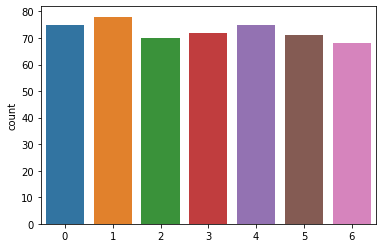

In [92]:
sns.countplot(x=y_train)

If similar counts for each digit, no need to downsample or upweigh.

## Check for NaN Values

In [93]:
print(np.isnan(x_train).any())
print(np.isnan(x_test).any())

False
False


In [94]:
print(x_train.shape)
print(x_test.shape)

(509, 1600, 1)
(51, 1600, 1)


In [95]:
input_shape=x_train.shape
print(input_shape)
output_shape=y_train.shape
print(output_shape)

(509, 1600, 1)
(509,)


In [96]:
x_train = x_train.reshape(-1,1600)
x_test = x_test.reshape(-1,1600)

In [97]:
import autosklearn.classification

input_shape=x_train.shape
print(input_shape)
output_shape=y_train.shape
print(output_shape)

(509, 1600)
(509,)


In [98]:
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=2*60, per_run_time_limit=30, n_jobs=4)
cls.fit(x_train, y_train)

AutoSklearnClassifier(n_jobs=4, per_run_time_limit=30,
                      time_left_for_this_task=120)

In [99]:
print(cls.sprint_statistics()) # best validation was about 0.26 for channel index 6

auto-sklearn results:
  Dataset name: a93e10cb-ab6b-11ec-93b4-c8d9d221ed1d
  Metric: accuracy
  Best validation score: 0.261905
  Number of target algorithm runs: 56
  Number of successful target algorithm runs: 45
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 5



In [100]:
pred = cls.predict(x_test)
sum(pred == y_test)/len(y_test)

0.27450980392156865

In [101]:
ensemble_dict = cls.show_models()
print(ensemble_dict)

{56: {'model_id': 56, 'rank': 1, 'cost': 0.7380952380952381, 'ensemble_weight': 0.020000000000000004, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f509eabc970>, 'balancing': Balancing(random_state=1, strategy='weighting'), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f507ba08a00>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f507bc2c160>, 'sklearn_classifier': MLPClassifier(alpha=0.00010000000000000026, beta_1=0.999, beta_2=0.9,
              early_stopping=True, hidden_layer_sizes=(33, 33, 33),
              learning_rate_init=0.0011616931802204656, max_iter=32,
              n_iter_no_change=32, random_state=1, verbose=0, warm_start=True)}, 4: {'model_id': 4, 'rank': 2, 'cost': 0.7440476190476191, 'ensemble_weight': 0.020000000000000004, 'data_preprocessor': <autosklearn.pipeline.components.data_preproc